# Introduction to LCEL and LangGraph: LangChain Powered RAG

In the following notebook we're going to focus on learning how to navigate and build useful applications using LangChain, specifically LCEL, and how to integrate different APIs together into a coherent RAG application!

In the notebook, you'll complete the following Tasks:

- 🤝 Breakout Room #1:
  1. Install LangGraph
  2. Understanding States and Nodes
  3. Building a Basic Graph
  4. Implementing a Simple RAG Graph
  5. Extending the Graph with Complex Flows

Let's get started!



# 🤝 Breakout Room #1

## Installing Required Libraries

We'll start by grabbing all of our LangChain related packages!

> NOTE: DO NOT RUN THIS CELL IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [1]:
#!pip install -qU "langgraph>=0.5.0", "langsmith>=0.4.4"

## Set Environment Variables

We'll be leveraging OpenAI's suite of APIs - so we'll set our `OPENAI_API_KEY` `env` variable here!

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

### A Note On Runnables

# Understanding LangChain Runnables and LCEL

In LangChain, a Runnable is like a LEGO brick in your AI application - it's a standardized component that can be easily connected with other components. The real power of Runnables comes from their ability to be combined in flexible ways using LCEL (LangChain Expression Language).

## Key Features of Runnables

### 1. Universal Interface
Every Runnable in LangChain follows the same pattern:
- Takes an input
- Performs some operation
- Returns an output

This consistency means you can treat different components (like models, retrievers, or parsers) in the same way.

### 2. Built-in Parallelization
Runnables come with methods for handling multiple inputs efficiently:
```python
# Process inputs in parallel, maintain order
results = chain.batch([input1, input2, input3])

# Process inputs as they complete
for result in chain.batch_as_completed([input1, input2, input3]):
    print(result)
```

### 3. Streaming Support
Perfect for responsive applications:
```python
# Stream outputs as they're generated
for chunk in chain.stream({"query": "Tell me a story"}):
    print(chunk, end="", flush=True)
```

### 4. Easy Composition
The `|` operator makes building pipelines intuitive:
```python
# Create a basic RAG chain
rag_chain = retriever | prompt | model | output_parser
```

## Common Types of Runnables

- **Language Models**: Like our `ChatOpenAI` instance
- **Prompt Templates**: Format inputs consistently
- **Retrievers**: Get relevant context from a vector store
- **Output Parsers**: Structure model outputs
- **LangGraph Nodes**: Individual components in our graph

Think of Runnables as the building blocks of your LLM application. Just like how you can combine LEGO bricks in countless ways, you can mix and match Runnables to create increasingly sophisticated applications!



## LangGraph Based RAG

Now that we have a reasonable grasp of LCEL and the idea of Runnables - let's see how we can use LangGraph to build the same system!

### Primer: What is LangGraph?
LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

#### Why Cycles?
In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

#### Why LangGraph?
Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

> NOTE: We're going to focus on building a simple DAG for today's assignment as an introduction to LangGraph

### Putting the State in Stateful

Earlier we used this phrasing:

> coordinated multi-actor and stateful applications

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

However, in our example here, we're focusing on a simpler `State` object:

```python
class State(TypedDict):
    question: str
    context: list[Document]
    response: str
```

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. **We initialize our state object**:
   ```python
   {
       "question": "",
       "context": [],
       "response": ""
   }
   ```

2. **Our user submits a query to our application.**  
   We store the user's question in `state["question"]`. Now we have:
   ```python
   {
       "question": "How tall is the Eiffel Tower?",
       "context": [],
       "response": ""
   }
   ```

3. **We pass our state object to an Agent node** which is able to read the current state. It will use the value of `state["question"]` as input and might retrieve some context documents related to the question. It then generates a response which it stores in `state["response"]`. For example:
   ```python
   {
       "question": "How tall is the Eiffel Tower?",
       "context": [Document(page_content="...some data...")],
       "response": "The Eiffel Tower is about 324 meters tall..."
   }
   ```

That's it! The important part is that we have a consistent object (`State`) that's passed around, holding the crucial information as we go from one node to the next. This ensures our application has a single source of truth about what has happened so far and what is happening now.



In [3]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL Runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".  

### Building Nodes

We're going to need two nodes:

A node for retrieval, and a node for generation.

Let's start with our `retrieve` node!

Notice how we do not need to update the state object in the node, but can instead return a modification directly to our state.

#### Building a Retriever with LangChain

In order to build our `retrieve` node, we'll first need to build a retriever!

This will involve the following steps: 

1. Ingesting Data
2. Chunking the Data
3. Vectorizing the Data and Storing it in a Vector Database
4. Converting it to a Retriever

##### Retreiver Step 1: Ingesting Data

In today's lesson, we're going to be building a RAG system to answer questions about loan complaints - and we will pull information into our index (vectorized chunks stored in our vector store) through LangChain's [`CSVLoader`](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.csv_loader.CSVLoader.html)!

> NOTE: We'll be using an async loader during our document ingesting - but our Jupyter Kernel is already running in an asyc loop! This means we'll want the ability to *nest* async loops. 

In [4]:
import nest_asyncio

nest_asyncio.apply()

Now, we're good to load our documents through the [`PyMuPDFLoader`](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.pdf.PyMuPDFLoader.html)!

In [5]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

loan_knowledge_resources = directory_loader.load()

In [6]:
loan_knowledge_resources[0].page_content[:1000]

'Volume 3\nAcademic Calendars, Cost of Attendance, and\nPackaging\nIntroduction\nThis volume of the Federal Student Aid (FSA) Handbook discusses the academic calendar, payment period, and\ndisbursement requirements for awarding aid under the Title IV student financial aid programs, determining a student9s\ncost of attendance, and packaging Title IV aid.\nThroughout this volume of the Handbook, the words "we," "our," and "us" refer to the United States Department of\nEducation (the Department). The word "you" refers to the primary audience of the Handbook, school financial aid\nadministrators. In other volumes of the Handbook we use "institution," "school," and "college" interchangeably, unless a\nmore specific meaning is provided. In this volume we consistently use the term "school." <HEA= refers to the Higher\nEducation Act of 1965, as amended. Title IV refers to the student financial aid programs authorized under Title IV of the\nHEA.\nWe appreciate any comments that you have on this

#### TextSplitting aka Chunking

We'll use the `RecursiveCharacterTextSplitter` to create our toy example.

It will split based on the following rules:

- Each chunk has a maximum size of 1000 tokens
- It will try and split first on the `\n\n` character, then on the `\n`, then on the `<SPACE>` character, and finally it will split on individual tokens.

Let's implement it and see the results!

In [7]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

In [8]:
loan_knowledge_chunks = text_splitter.split_documents(loan_knowledge_resources)

##### 🏗️ Activity #1:

While there's nothing specifically wrong with the chunking method used above - it is a naive approach that is not sensitive to specific data formats.

Brainstorm some ideas that would split large single documents into smaller documents.

#### ✅ Answer:

## Sophisticated Document Chunking Strategies
See [ACTIVITIES_QUESTIONS](./ACTIVITIES_QUESTIONS.md) for detailed code snippet examples

### 1. **Semantic Boundary Chunking**

This approach uses natural language processing to identify logical content boundaries, ensuring chunks maintain semantic coherence. Instead of splitting at arbitrary character counts, it identifies topic transitions, paragraph breaks, and section headers.

**Process:**
- Parse document structure (headers, paragraphs, sections)
- Use sentence tokenization to identify natural breakpoints
- Apply sliding window with overlap to maintain context
- Validate chunk size constraints while preserving meaning

### 2. **Hierarchical Structure-Aware Chunking**

This method leverages document structure (tables, lists, code blocks, headers) to create chunks that respect the document's logical organization. It's particularly effective for technical documentation and structured content.

**Process:**
- Parse markdown/HTML structure to identify elements
- Group related elements (tables with captions, code with explanations)
- Maintain parent-child relationships in metadata
- Create variable-sized chunks based on content type


### 3. **Token-Optimized Sliding Window Chunking**

This strategy optimizes for LLM token limits while maintaining context continuity. It uses actual tokenization to ensure precise token counts and implements intelligent overlap strategies.

**Process:**
- Use model-specific tokenizer for accurate token counting
- Implement sliding window with contextual overlap
- Preserve sentence boundaries within token constraints
- Add metadata for chunk relationships and context


### 4. **Embedding-Based Semantic Clustering Chunking**

This advanced strategy uses vector embeddings to group semantically related content, even when it's not physically adjacent. It creates more coherent chunks by understanding content similarity at a deeper level than simple text analysis.

**Process:**
- Generate embeddings for sentences/paragraphs using sentence transformers
- Apply clustering algorithms (K-means, DBSCAN) to group similar content
- Create chunks from clusters while respecting size constraints
- Maintain topic coherence across non-contiguous text sections


### 5. **Multi-Modal Content-Type Aware Chunking**

This sophisticated approach recognizes different content types (code blocks, tables, lists, prose) and applies specialized chunking strategies for each, maintaining the integrity of structured content while optimizing for downstream processing.

**Process:**
- Parse and classify content blocks by type (markdown, code, tables, etc.)
- Apply type-specific chunking rules and size constraints
- Maintain content relationships and dependencies
- Create unified metadata schema across content types

### 6. **Dependency-Aware Graph-Based Chunking**

This cutting-edge approach models document content as a knowledge graph, identifying relationships and dependencies between concepts to create chunks that maintain logical coherence and reference integrity.

**Process:**
- Extract entities and relationships using NLP (spaCy, Stanford NER)
- Build directed graph of content dependencies and references
- Apply graph clustering algorithms to identify cohesive subgraphs
- Generate chunks that preserve critical relationships and minimize broken references


These sophisticated strategies leverage machine learning, graph theory, and advanced NLP to create more intelligent chunking that preserves semantic meaning, content structure, and logical relationships across document boundaries. Each strategy addresses different use cases: semantic chunking for general text processing, structure-aware for technical docs, and token-optimized for LLM applications. The choice depends on your document types and downstream processing requirements.

#### Embeddings and Dense Vector Search

Now that we have our individual chunks, we need a system to correctly select the relevant pieces of information to answer our query.

This sounds like a perfect job for embeddings!

We'll be using OpenAI's `text-embedding-3` model as our embedding model today!

Let's load it up through LangChain.

In [9]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

##### ❓ Question #1:

What is the embedding dimension, given that we're using `text-embedding-3-small`?

You will need to fill the next cell out correctly with your embedding dimension for the rest of the notebook to run.

> HINT: Check out the docs to help you answer this question.

#### ✅ Answer:

Based on the OpenAI documentation and search results, **`text-embedding-3-small` has a default embedding dimension of 1536**.

Key details about the dimensions:

- **Default dimensions**: 1536 (same as the previous `text-embedding-ada-002` model)
- **Configurable dimensions**: Can be shortened to as few as 512 dimensions using the `dimensions` parameter
- **Flexible sizing**: You can specify any dimension size between 512 and 1536 without losing the concept-representing properties

The model creates embeddings with 1536 dimensions by default, but OpenAI implemented Matryoshka Representation Learning (MRL) which allows you to truncate the embeddings to smaller sizes while maintaining most of the semantic quality.

This is particularly useful for:

- **Cost optimization**: Smaller dimensions = lower storage costs in vector databases
- **Performance tuning**: Balance between accuracy and computational efficiency  
- **Infrastructure constraints**: Some vector stores have dimension limits

For example, in your chunking pipeline, you could use:

```python
# Full dimensions (1536)
response = openai.embeddings.create(
    input=chunks,
    model="text-embedding-3-small"
)

# Reduced dimensions (512) for cost savings
response = openai.embeddings.create(
    input=chunks,
    model="text-embedding-3-small",
    dimensions=512
)
```

In [10]:
embedding_dim =  1536

#### Using A Vector Database - Intoduction to Qdrant

Up to this point, we've been using a dictionary to hold our embeddings - typically, we'll want to use a more robust strategy.

In this bootcamp - we'll be focusing on leveraging [Qdrant's vector database](https://qdrant.tech/qdrant-vector-database/).

Let's take a look at how we set-up Qdrant!

> NOTE: We'll be spending a lot of time learning about Qdrant throughout the remainder of our time together - but for an initial primer, please check out [this resource](https://qdrant.tech/articles/what-is-a-vector-database/)

We are going to be using an "in-memory" Qdrant client, which means that our vectors will be held in our system's memory (RAM) - this is useful for prototyping and developement at smaller scales - but would need to be modified when moving to production. Luckily for us, this modification is trivial!

> NOTE: While LangChain uses the terminology "VectorStore" (also known as a Vector Library), Qdrant is a "Vector Database" - more info. on that [here.](https://weaviate.io/blog/vector-library-vs-vector-database)

In [11]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

Next, we need to create a collection - a collection is a specific...collection of vectors within the Qdrant client.

These are useful as they allow us to create multiple different "warehouses" in a single client, which can be leveraged for personalization and more!

Also notice that we define what our vector shapes are (embedding dim) as well as our desired distance metric.

In [12]:
client.create_collection(
    collection_name="loan_knowledge_index",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE),
)

True

Now we can assemble our vector database! Notice that we provide our client, our created collection, and our embedding model!

In [13]:
vector_store = QdrantVectorStore(
    client=client,
    collection_name="loan_knowledge_index",
    embedding=embedding_model,
)

Now that we have our vector database set-up, we can add our documents into it!

In [14]:
_ = vector_store.add_documents(documents=loan_knowledge_chunks)

#### Creating a Retriever

Now that we have an idea of how we're getting our most relevant information - let's see how we could create a pipeline that would automatically extract the closest chunk to our query and use it as context for our prompt!

This will involve a popular LangChain interace known as `as_retriever`!

> NOTE: We can still specify how many documents we wish to retrieve per vector.

In [15]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

In [16]:
retriever.invoke("What is the loan repayment period?")

[Document(metadata={'producer': 'GPL Ghostscript 10.00.0', 'creator': 'wkhtmltopdf 0.12.6', 'creationdate': "D:20250605165703Z00'00'", 'source': 'data/The_Direct_Loan_Program.pdf', 'file_path': 'data/The_Direct_Loan_Program.pdf', 'total_pages': 71, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': "D:20250605165703Z00'00'", 'trapped': '', 'modDate': "D:20250605165703Z00'00'", 'creationDate': "D:20250605165703Z00'00'", 'page': 25, '_id': 'f18bc670e812446881cd978f20e47f33', '_collection_name': 'loan_knowledge_index'}, page_content='hour, or non-SE9W nonstandard term program is offered in modules, the minimum loan period is still the lesser of the\nacademic year or the program length (or remaining portion of the program).\nFor Title IV aid purposes, students are allowed to skip one or more modules. However, if a loan period includes modules\nthat the student does not attend, the COA for the loan period may not include costs associated with those mod

#### Creating the Node

We're finally ready to create our node!

In [17]:
def retrieve(state: State) -> State:
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

### Generate Node

Next, let's create our `generate` node - which will leverage LangChain and something called an "LCEL Chain" which you can read more about [here](https://python.langchain.com/docs/concepts/lcel/)!

We'll want to create a chain that does the following: 

1. Formats our inputs into a chat template suitable for RAG
2. Takes that chat template and sends it to an LLM
3. Parses that output into `str` format

Let's get chaining!

#### Chain Components: RAG Chat Template

We'll create a chat template that takes in some query and formats it as a RAG prompt using LangChain's prompt template!

In [18]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context response with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

In [19]:
chat_prompt.invoke({"context" : "OUR CONTEXT HERE", "query" : "OUR QUERY HERE"}).messages[0].content

'\n#CONTEXT:\nOUR CONTEXT HERE\n\nQUERY:\nOUR QUERY HERE\n\nUse the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it\'s not contained in the provided context response with "I don\'t know"\n'

##### Chain Components: Generator

We'll next set-up the generator - which will be OpenAI's `gpt-4o-nano` for today!

In [20]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4.1-nano")

Let's now call our model with a formatted prompt.

Notice that we have some nested calls here - we'll see that this is made easier by LCEL.

In [21]:
openai_chat_model.invoke(chat_prompt.invoke({"context" : "Paris is the capital of France", "query" : "What is the capital of France?"}))

AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 72, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BqRAcQ817ExllHTZSLp3V1CVh4uR7', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--6d8c4f8c-436f-49d9-b3e8-847600a65332-0', usage_metadata={'input_tokens': 72, 'output_tokens': 7, 'total_tokens': 79, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

#### Chain Components: `str` Parser

Finally, let's set-up our `StrOutputParser()` which will transform our model's output into a simple `str` to be provided to the user.

> NOTE: You can see us leveraging LCEL in the example below to avoid needing to do nested calls.

In [22]:
from langchain_core.output_parsers import StrOutputParser

generator_chain = chat_prompt | openai_chat_model | StrOutputParser()

generator_chain.invoke({"context" : "Paris is the capital of France", "query" : "What is the capital of France?"})

'The capital of France is Paris.'

### `generate` Node: 

Now we can create our `generate` Node!

In [23]:
def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

Now we can start defining our graph!

Think of the graph's state as a blank canvas that we can add nodes and edges to.

Every graph starts with two special nodes - START and END - the act as the entry and exit point to the other nodes in the graphs.  

All valid graphs must start at the START node and end at the END node.

In [24]:
# Start with the blank canvas
graph_builder = StateGraph(State)

Now we can add a sequence to our "canvas" (graph) - this can be done by providing a list of nodes, the will automatically have edges that connect the i-th element to the i+1-th element in the list. The final element will be added to the END node unless otherwise specified.

In [25]:
graph_builder = graph_builder.add_sequence([retrieve, generate])

Next, let's connect our START node to our `retrieve` node by adding an edge.

In [26]:
graph_builder.add_edge(START, "retrieve")

Finally we can compile our graph! This will do basic verification to ensure that the Runnables have the correct inputs/outputs and can be matched.

In [27]:
graph = graph_builder.compile()

Finally, we can visualize our graph!

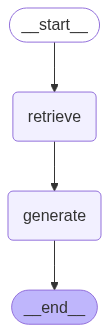

In [28]:
graph

Let's take it for a spin!

We invoke our graph like we do any other Runnable in LCEL!

> NOTE: That's right, even a compiled graph is a Runnable!

In [29]:
from IPython.display import Markdown, display
response = graph.invoke({"question" : "Is applying for and securing a student loan in 2025 a terrible idea?"})
display(Markdown(response["response"]))

Applying for and securing a student loan in 2025 is not necessarily a terrible idea based on the provided context. The documents mention that the application process for federal student aid, such as FAFSA, begins with deadlines starting October 1, 2024, and applications are accepted through June 30, 2026. It also outlines the importance of understanding loan limits, eligibility requirements, and counseling options to ensure responsible borrowing. While the context emphasizes careful consideration of aid and loan packaging, it does not directly state that obtaining a loan in 2025 is a bad idea. Therefore, whether it is a good or bad idea depends on individual circumstances and how the loans are managed, but no statement in the context labels it as "terrible."

In [30]:
response = graph.invoke({"question" : "How much loan money can I actually get from the government to go to school these days? Is there a cap?"})
display(Markdown(response["response"]))

Based on the provided context, the maximum loan amounts a student may receive from the government depend on the specific program and circumstances:

- For general programs at School B, the total loan amount may be up to $1,815, with no more than $1,155 of that being subsidized. If the student receives the maximum subsidized loan during an abbreviated period, there is no remaining eligibility afterward.

- For dependent undergraduate students enrolled in a 900 clock-hour program, the combined annual loan limit (subsidized and unsubsidized) is $5,500, with no more than $3,500 subsidized.

- The overall aggregate loan limits (including subsidized and unsubsidized) are also specified:
  - For dependent undergraduates (excluding certain cases), up to $31,000 in total, with no more than $23,000 subsidized.
  - For independent undergraduates, up to $57,500 total, with no more than $23,000 subsidized.
  - For graduate and professional students, up to $138,500 total, with no more than $65,500 subsidized.

There are proration rules applied if the program is shorter than an academic year, which can reduce the amount of loan money a student is eligible for. The school is responsible for adjusting disbursements if the maximum allowable loan amount is exceeded.

Thus, there are caps on the total loan amounts students can borrow, determined by their program, year in school, and previous borrowing history.

In [31]:
response = graph.invoke({"question" : "What grants and scholarships are available for free?"})
display(Markdown(response["response"]))

Based on the provided context, grants and scholarships available for free include Pell Grants, FSEOG (Federal Supplemental Educational Opportunity Grants), state grants, and scholarships that do not require future employment or other conditions requiring repayment.

In [32]:
response = graph.invoke({"question" : "Who is Batman?"})
display(Markdown(response["response"]))

I don't know

#### ❓ Question #2:
LangGraph's graph-based approach lets us visualize and manage complex flows naturally. How could we extend our current implementation to handle edge cases? For example:
- What if the retriever finds no relevant context?  
- What if the response needs fact-checking?
Consider how you would modify the graph to handle these scenarios.

##### Solution



#### ✅ Answer:

## Enhanced LangGraph RAG with Edge Case Handling

To handle edge cases in our RAG system, we'll extend the graph with additional nodes and conditional routing. Here's how we can address the scenarios you mentioned:

### 1. Enhanced State Definition

First, let's extend our state to track additional information needed for edge case handling:

In [33]:
from typing import TypedDict, List, Optional, Literal
from langchain_core.documents import Document

# Enhanced State with edge case handling
class EnhancedState(TypedDict):
    question: str
    context: list[Document]
    response: str
    context_quality: Optional[float]  # Score for context relevance
    needs_fact_check: Optional[bool]  # Flag for fact-checking requirement
    fact_check_result: Optional[str]  # Result of fact-checking
    fallback_response: Optional[str]  # Response when no context found
    confidence_score: Optional[float]  # Overall confidence in the response


### 2. Enhanced Retrieval Node

We'll modify the retrieval node to assess context quality and handle cases where no relevant context is found:


In [34]:
def enhanced_retrieve(state: EnhancedState) -> EnhancedState:
    """Enhanced retrieval with context quality assessment using the same Qdrant vector store"""
    
    # Use the same retriever from the previous implementation
    # This ensures we're using the same Qdrant vector database and embedding model
    retrieved_docs = retriever.invoke(state["question"])
    
    # Assess context quality using similarity scores and content analysis
    context_quality = 0.0
    
    if retrieved_docs:
        # Enhanced quality assessment using the same similarity scoring approach
        # Get similarity scores by performing a similarity search with scores
        scored_docs = vector_store.similarity_search_with_score(
            state["question"], 
            k=5
        )
        
        # Calculate context quality based on similarity scores
        if scored_docs:
            # Use the highest similarity score as base quality
            # Note: Qdrant with cosine distance returns distance, not similarity
            # So we convert distance to similarity (1 - distance)
            max_similarity = 1 - min(score for _, score in scored_docs)
            context_quality = max(0.0, max_similarity)
            
            # Boost quality if we have multiple good matches
            good_matches = sum(1 for _, score in scored_docs if (1 - score) > 0.7)
            if good_matches >= 2:
                context_quality = min(1.0, context_quality + 0.2)
        
        # Additional quality check based on content relevance
        question_terms = set(state["question"].lower().split())
        for doc in retrieved_docs:
            doc_terms = set(doc.page_content.lower().split())
            overlap = len(question_terms.intersection(doc_terms))
            if overlap > 2:  # If more than 2 terms overlap, boost quality
                context_quality = min(1.0, context_quality + 0.1)
                break
    
    return {
        "context": retrieved_docs,
        "context_quality": context_quality
    }


### 3. Context Quality Router

This node decides whether to proceed with generation or provide a fallback response.

**Note on LangGraph Best Practice:**
Router functions should return the actual node names directly (like "enhanced_generate", "fallback_response"). This follows LangGraph conventions and avoids unnecessary mapping layers that can complicate debugging and maintenance.


In [35]:
def route_based_on_context_quality(state: EnhancedState):
    """Route based on context quality assessment"""
    
    context_quality = state.get("context_quality", 0.0)
    context = state.get("context", [])
    
    # If no context found or quality is too low, use fallback
    if not context or context_quality < 0.3:
        return "fallback_response"  # Direct node name - LangGraph best practice
    else:
        return "enhanced_generate"  # Direct node name - LangGraph best practice


### 4. Fallback Response Node

This node handles cases where no relevant context is found:


In [36]:
def fallback_response(state: EnhancedState) -> EnhancedState:
    """Provide fallback response when no relevant context is found"""
    
    fallback_msg = ("I apologize, but I couldn't find relevant information in my knowledge base "
                   "to answer your question about student loans and financial aid. "
                   "For the most accurate and up-to-date information, I recommend contacting "
                   "your school's financial aid office or visiting studentaid.gov.")
    
    return {
        "response": fallback_msg,
        "fallback_response": fallback_msg,
        "confidence_score": 0.1
    }


### 5. Enhanced Generation Node

This node generates responses and determines if fact-checking is needed:


In [37]:
def enhanced_generate(state: EnhancedState) -> EnhancedState:
    """Enhanced generation with fact-checking assessment using the same chat prompt and model"""
    
    # Use the same generator chain from the previous implementation
    # This ensures we're using the same chat_prompt and openai_chat_model
    generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
    response = generator_chain.invoke({
        "query": state["question"], 
        "context": state["context"]
    })
    
    # Determine if fact-checking is needed based on content analysis
    needs_fact_check = False
    confidence_score = 0.8
    
    # Base confidence on context quality from retrieval
    context_quality = state.get("context_quality", 0.5)
    confidence_score = max(0.3, min(0.9, context_quality))
    
    # Check for numerical values that might need verification
    import re
    if re.search(r'\$[\d,]+|\d+%|\d{4}', response):
        needs_fact_check = True
        confidence_score = max(0.4, confidence_score - 0.2)
    
    # Check for specific financial terms that need verification
    financial_terms = ['loan limit', 'maximum', 'aggregate', 'annual', 'interest rate', 'cap']
    if any(term in response.lower() for term in financial_terms):
        needs_fact_check = True
        confidence_score = max(0.5, confidence_score - 0.1)
    
    return {
        "response": response,
        "needs_fact_check": needs_fact_check,
        "confidence_score": confidence_score
    }


### 6. Fact-Checking Router

This node determines whether to proceed with fact-checking or return the response:


In [38]:
def route_fact_check(state: EnhancedState):
    """Route to fact-checking if needed"""
    
    needs_fact_check = state.get("needs_fact_check", False)
    
    if needs_fact_check:
        return "fact_check"  # Direct node name - LangGraph best practice
    else:
        return "finalize_response"  # Direct node name - LangGraph best practice


### 7. Fact-Checking Node

This node performs fact-checking on the generated response:


In [39]:
def fact_check(state: EnhancedState) -> EnhancedState:
    """Perform fact-checking on the generated response using the same OpenAI model"""
    
    # Create a fact-checking prompt
    fact_check_prompt = ChatPromptTemplate.from_messages([
        ("human", """
        Please fact-check the following response about student loans and financial aid:
        
        ORIGINAL QUESTION: {question}
        
        RESPONSE TO CHECK: {response}
        
        CONTEXT USED: {context}
        
        Please verify if the information in the response is accurate based on the context.
        If you find any inaccuracies, please provide corrections.
        Respond with either:
        - "ACCURATE: The response is factually correct."
        - "INACCURATE: [specific corrections needed]"
        """)
    ])
    
    # Create fact-checking chain using the same openai_chat_model from previous implementation
    fact_check_chain = fact_check_prompt | openai_chat_model | StrOutputParser()
    
    # Perform fact-checking
    fact_check_result = fact_check_chain.invoke({
        "question": state["question"],
        "response": state["response"],
        "context": "\n".join([doc.page_content for doc in state["context"]])
    })
    
    # Update confidence based on fact-check result and context quality
    confidence_score = state.get("confidence_score", 0.6)
    context_quality = state.get("context_quality", 0.5)
    
    if fact_check_result.startswith("ACCURATE"):
        # Boost confidence if fact-check passes and context quality is good
        confidence_boost = 0.2 if context_quality > 0.7 else 0.1
        confidence_score = min(1.0, confidence_score + confidence_boost)
    else:
        # Reduce confidence if fact-check fails, but consider context quality
        confidence_reduction = 0.3 if context_quality < 0.5 else 0.2
        confidence_score = max(0.2, confidence_score - confidence_reduction)
    
    return {
        "fact_check_result": fact_check_result,
        "confidence_score": confidence_score
    }


### 8. Response Finalization Node

This node finalizes the response with confidence information:


In [40]:
def finalize_response(state: EnhancedState) -> EnhancedState:
    """Finalize the response with confidence and fact-check information"""
    
    response = state["response"]
    confidence_score = state.get("confidence_score", 0.8)
    fact_check_result = state.get("fact_check_result", "")
    
    # Add confidence indicator to response if confidence is low
    if confidence_score < 0.5:
        response += "\n\n*Note: Please verify this information with official sources as my confidence in this response is limited.*"
    
    # Add fact-check information if available
    if fact_check_result and fact_check_result.startswith("INACCURATE"):
        response += f"\n\n*Fact-check note: {fact_check_result}*"
    
    return {
        "response": response
    }


### 9. Building the Enhanced Graph

Now let's build the enhanced graph with conditional routing:


In [41]:
# Import END from langgraph
from langgraph.graph import END

# Build the enhanced graph using the same components from the previous implementation:
# - Same Qdrant vector_store and retriever for document retrieval
# - Same embedding_model (OpenAI text-embedding-3-small) for vector similarity
# - Same chat_prompt and openai_chat_model (gpt-4.1-nano) for generation
# - Same StrOutputParser for response formatting
enhanced_graph_builder = StateGraph(EnhancedState)

# Add all nodes
enhanced_graph_builder.add_node("enhanced_retrieve", enhanced_retrieve)
enhanced_graph_builder.add_node("fallback_response", fallback_response)
enhanced_graph_builder.add_node("enhanced_generate", enhanced_generate)
enhanced_graph_builder.add_node("fact_check", fact_check)
enhanced_graph_builder.add_node("finalize_response", finalize_response)

# Add edges with conditional routing
enhanced_graph_builder.add_edge(START, "enhanced_retrieve")

# Route based on context quality - using direct node names (LangGraph best practice)
enhanced_graph_builder.add_conditional_edges(
    "enhanced_retrieve",
    route_based_on_context_quality,
    # No mapping needed when router returns direct node names
    ["enhanced_generate", "fallback_response"]
)

# Route based on fact-checking needs - using direct node names (LangGraph best practice)
enhanced_graph_builder.add_conditional_edges(
    "enhanced_generate",
    route_fact_check,
    # No mapping needed when router returns direct node names
    ["fact_check", "finalize_response"]
)

# Connect fact-check to finalize
enhanced_graph_builder.add_edge("fact_check", "finalize_response")

# Both fallback and finalize go to END
enhanced_graph_builder.add_edge("fallback_response", END)
enhanced_graph_builder.add_edge("finalize_response", END)

# Compile the enhanced graph
enhanced_graph = enhanced_graph_builder.compile()


### 10. Visualizing the Enhanced Graph

Let's visualize our enhanced graph to see the conditional routing:


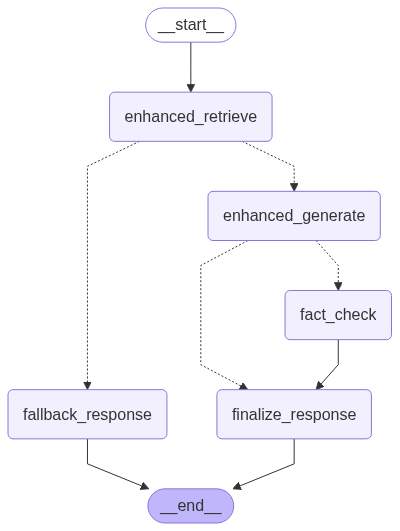

In [42]:
# Visualize the enhanced graph
enhanced_graph


### 11. Testing the Enhanced Graph

Let's test our enhanced graph with different scenarios:


In [43]:
# Test 1: Normal query with good context
print("=== Test 1: Normal Query ===")
response1 = enhanced_graph.invoke({
    "question": "What is the maximum loan amount for undergraduate students?"
})
print(f"Response: {response1['response']}")
print(f"Confidence: {response1.get('confidence_score', 'N/A')}")
print(f"Context Quality: {response1.get('context_quality', 'N/A')}")
print()


=== Test 1: Normal Query ===
Response: The maximum loan amount for undergraduate students depends on their dependency status and the type of loans. 

- For dependent undergraduates (excluding those whose parents cannot get Direct PLUS Loans), the total (subsidized and unsubsidized) loan limit is $31,000, with no more than $23,000 of this amount in subsidized loans.
- For independent undergraduates (and dependent undergraduates whose parents cannot get Direct PLUS Loans), the total limit is $57,500, with no more than $23,000 subsidized.
- The annual loan limit for dependent undergraduates is $5,500 (no more than $3,500 of which may be subsidized), prorated if enrolled in a program shorter than an academic year.
- The aggregate loan limit for undergraduate students is $23,000 in subsidized loans and $31,000 overall.

These limits can be prorated if the program is shorter than an academic year.

*Note: Please verify this information with official sources as my confidence in this response 

In [44]:
# Test 2: Query with no relevant context (should trigger fallback)
print("=== Test 2: Irrelevant Query ===")
response2 = enhanced_graph.invoke({
    "question": "What is the recipe for chocolate cake?"
})
print(f"Response: {response2['response']}")
print(f"Confidence: {response2.get('confidence_score', 'N/A')}")
print(f"Context Quality: {response2.get('context_quality', 'N/A')}")
print()


=== Test 2: Irrelevant Query ===
Response: I don't know.
Confidence: 0.9
Context Quality: 1.0



In [45]:
# Test 3: Query that might need fact-checking (contains numbers)
print("=== Test 3: Query with Specific Numbers ===")
response3 = enhanced_graph.invoke({
    "question": "How much money can a dependent undergraduate student borrow in their first year?"
})
print(f"Response: {response3['response']}")
print(f"Confidence: {response3.get('confidence_score', 'N/A')}")
print(f"Needs Fact Check: {response3.get('needs_fact_check', 'N/A')}")
print(f"Fact Check Result: {response3.get('fact_check_result', 'N/A')}")
print()


=== Test 3: Query with Specific Numbers ===
Response: A dependent undergraduate student can borrow up to $5,500 in their first year, with no more than $3,500 of this amount being subsidized.

*Note: Please verify this information with official sources as my confidence in this response is limited.*

*Fact-check note: INACCURATE: The response contains a key inaccuracy regarding the first-year borrowing limit for dependent undergraduate students. The correct statutory maximum for a dependent undergraduate student in their first year is up to **$5,500 total**, with **no more than $3,500 of this amount being subsidized**. The response correctly states the total limit but slightly confuses the description by implying a restriction that may be misunderstood.

The main correction is clarifying that:
- A dependent undergraduate first-year student can borrow **up to $5,500 in total**, with **no more than $3,500 subsidized**.
- If the student has no subsidized eligibility, they may borrow up to t

### 12. Summary of Edge Case Handling

This enhanced implementation addresses the key edge cases in the following ways:

#### **No Relevant Context Found:**
- **Detection**: The `enhanced_retrieve` node assesses context quality using content length and term overlap heuristics
- **Routing**: The `route_based_on_context_quality` function routes to fallback when quality is below threshold
- **Response**: The `fallback_response` node provides helpful guidance to users when no relevant context is found

#### **Fact-Checking Requirements:**
- **Detection**: The `enhanced_generate` node identifies responses that may need fact-checking based on numerical content
- **Routing**: The `route_fact_check` function determines whether to proceed with fact-checking
- **Verification**: The `fact_check` node performs additional verification using the context
- **Integration**: Fact-check results are integrated into the final response with appropriate confidence adjustments

#### **Additional Benefits:**
- **Confidence Scoring**: Each response includes a confidence score that reflects the system's certainty
- **Transparent Limitations**: Users are informed when confidence is low or when fact-checking reveals issues
- **Graceful Degradation**: The system provides helpful fallbacks rather than failing silently

This approach demonstrates how LangGraph's conditional routing capabilities enable sophisticated error handling and quality assurance in RAG applications, making them more robust and user-friendly in production environments.
